# Grafica de mapas

In [48]:
import pandas as pd
import geopandas as gpd
import ipywidgets as widgets
import os
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

In [2]:
data_path = './data'
tidy_path = data_path + '/tidy'
semaforo = pd.read_csv(tidy_path + '/delitos_semaforo.csv', encoding = 'iso-8859-1')
gdf = gpd.read_file('./data/conjunto_de_datos/areas_geoestadisticas_estatales.shp', 
                    columns = ["clave_entidad", 'nombre_entidad', 'geometry'])
poblacion = pd.read_excel('./data/0_Pob_Inicio_1950_2070.xlsx', sheet_name= 0,)

In [3]:
poblacion_2 = poblacion.groupby(['AÑO','ENTIDAD'])['POBLACION'].sum().reset_index()
poblacion_2 = poblacion_2[(poblacion_2['AÑO'] <= 2023) & (poblacion_2['AÑO'] >= 2015)]
poblacion_2 = poblacion_2[~(poblacion_2['ENTIDAD'] == 'República Mexicana' )]

## Evolucion de poblacion 2015 - 2023

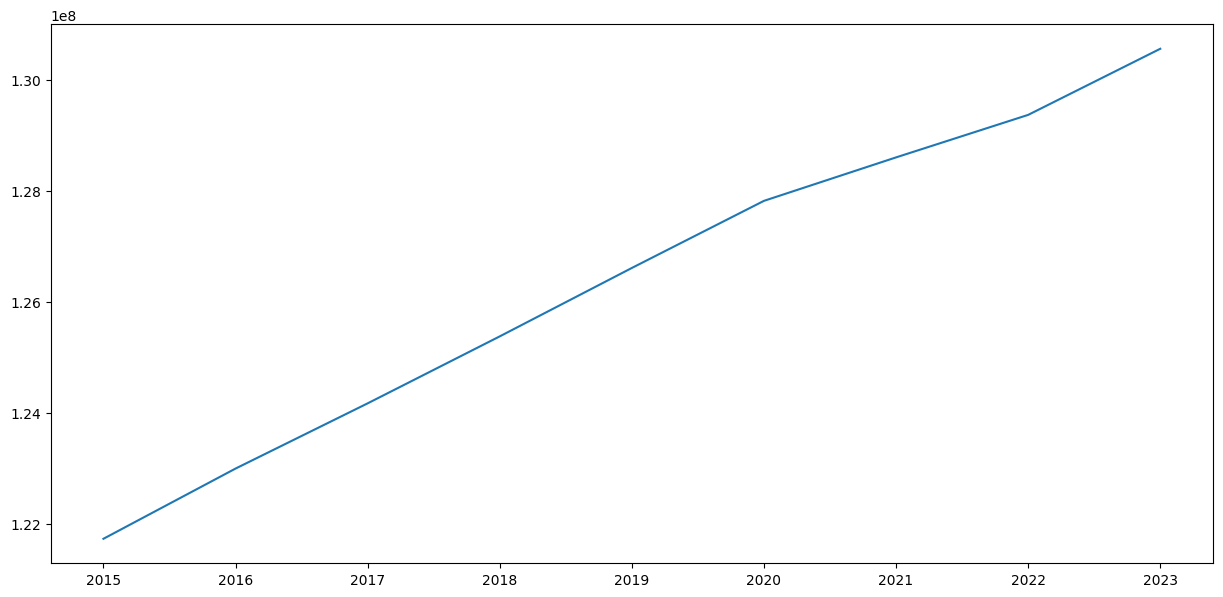

In [4]:
fig, ax = plt.subplots(1,1, figsize = (15,7))
ax.plot(poblacion_2.groupby('AÑO').sum().index,  poblacion_2.groupby('AÑO')["POBLACION"].sum().values);

In [5]:
meses = semaforo.columns[10:22]

semaforo2 = semaforo.replace(to_replace = 'Veracruz de Ignacio de la Llave', value = 'Veracruz')\
    .groupby(['anio', 'entidad','delito_semaforo'])[meses].sum()\
    .sum(axis = 1)\
    .to_frame()\
    .reset_index()
    

semaforo2.rename(columns = {0:'incidentes'}, inplace = True)

Revizando que nombre de estados sean los mismos

In [6]:
gdf.replace({'Veracruz de Ignacio de la Llave':'Veracruz'}, inplace = True)
set(gdf['NOM_ENT']) == set(semaforo2['entidad'])

True

In [7]:
poblacion_2.ENTIDAD.replace({'Michoacán':'Michoacán de Ocampo','Coahuila':'Coahuila de Zaragoza'}, inplace = True)
set(semaforo2['entidad']) == set(poblacion_2.ENTIDAD)

True

In [41]:
geometrias = pd.merge(poblacion_2, gdf, left_on = 'ENTIDAD', right_on = 'NOM_ENT', how = 'outer')\
    .drop(columns = ['CVE_ENT', 'NOM_ENT'])

geometrias = geometrias.merge(semaforo2, left_on = 'ENTIDAD', right_on = 'entidad', how = 'left')\
    .drop(columns  = ['AÑO', 'ENTIDAD'])\
    .rename(columns = {'POBLACION':'poblacion'})\
    [['anio', 'entidad', 'geometry', 'poblacion', 'delito_semaforo', 'incidentes']] #ordenar de una vez
geometrias['incidentes_per_10000_hab'] = 100000 * geometrias['incidentes'] / geometrias['poblacion']

#lo pasamos a geopandas porque se perdio
geometrias = gpd.GeoDataFrame(geometrias)
geometrias

,anio,entidad,geometry,poblacion,delito_semaforo,incidentes,incidentes_per_10000_hab
0,2015,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",1332990,Extorsión,39,2.925753
1,2015,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",1332990,Feminicidio,0,0.000000
2,2015,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",1332990,Homicidios,38,2.850734
3,2015,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",1332990,Lesiones,2289,171.719218
4,2015,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",1332990,Narcomenudeo,614,46.061861
...,...,...,...,...,...,...,...
28507,2023,Zacatecas,"POLYGON ((2515182.307 1441549.749, 2515937.734...",1675298,Robo a negocio,227,13.549828
28508,2023,Zacatecas,"POLYGON ((2515182.307 1441549.749, 2515937.734...",1675298,Robo a vehículo,1448,86.432384
28509,2023,Zacatecas,"POLYGON ((2515182.307 1441549.749, 2515937.734...",1675298,Secuestros,5,0.298454
28510,2023,Zacatecas,"POLYGON ((2515182.307 1441549.749, 2515937.734...",1675298,Violación,122,7.282286


In [55]:
warnings.filterwarnings("ignore")
def graficar_mapa(delito, año = 2022):
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    
    vista = geometrias[(geometrias['delito_semaforo'] == delito) & (geometrias['anio'] == año)]
    
    vista.plot(column = 'incidentes_per_10000_hab', 
               scheme = 'quantiles', 
               k = 3, 
               legend=True, 
               cmap='Reds', 
               ax = ax,
               edgecolor='black', 
               linewidth=0.3) 

    leg = ax.get_legend()
    leg.set_title("Incidentes cada 10,000 habitantes")
    ax.set_title(delito)
    ax.set_axis_off()
    

widgets.interact(graficar_mapa, delito = geometrias.delito_semaforo.unique(), año = range(2015, 2023));
    

interactive(children=(Dropdown(description='delito', options=('Extorsión', 'Feminicidio', 'Homicidios', 'Lesio…